In [17]:
import numpy as np
import sys

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Dropout, Input
from keras.optimizers import RMSprop, Adam

from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import tensorflow as tf

In [18]:
print(tf.__version__)
print(keras.__version__)

1.1.0
2.0.8


## Load the corpus

In [19]:
# load ascii text and covert to lowercase
filename = "wonderland.txt"
raw_text = open(filename).read()
raw_text = raw_text.lower()

## Make look up tables based on characters

In [20]:
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Unique chars: ", n_vocab)

Total Characters:  144345
Total Unique chars:  46


In [21]:
#raw_text = raw_text[1:]
len(int_to_char)

46

## Make the sequences

This shows you an example of making sequences sampled from the overall text data. 

We are creating sequences that are 100 characters long

In [22]:
# create input and output pairs
seq_length = 100
dataX = []
dataY = []
dataZ = [] #
for i in range(0, n_chars - seq_length - 10, 1): # 10 for analysis of the tail of the sequence
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    seq_out_extended = raw_text[(i + seq_length):(i + seq_length + 10)]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
    dataZ.append([char_to_int[char] for char in seq_out_extended])
n_patterns = len(dataX)
print("Total sequences: ", n_patterns)

Total sequences:  144235


### Lets examine some of these sequences

In [23]:
print(dataX[0])
print(dataY[0])

[44, 43, 45, 19, 24, 17, 32, 36, 21, 34, 1, 25, 10, 1, 20, 31, 39, 30, 1, 36, 24, 21, 1, 34, 17, 18, 18, 25, 36, 9, 24, 31, 28, 21, 0, 0, 17, 28, 25, 19, 21, 1, 39, 17, 35, 1, 18, 21, 23, 25, 30, 30, 25, 30, 23, 1, 36, 31, 1, 23, 21, 36, 1, 38, 21, 34, 41, 1, 36, 25, 34, 21, 20, 1, 31, 22, 1, 35, 25, 36, 36, 25, 30, 23, 1, 18, 41, 1, 24, 21, 34, 1, 35, 25, 35, 36, 21, 34, 1, 31]
30


In [24]:
print(dataZ[0])
print(dataZ[0][2])


[30, 1, 36, 24, 21, 0, 18, 17, 30, 27]
36


In [25]:
print("\"", ''.join([int_to_char[value] for value in dataX[0]]), "\"")
print(int_to_char[dataY[0]])

" п»їchapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister o "
n


In [26]:
print(dataX[1])
print(dataY[1])

[43, 45, 19, 24, 17, 32, 36, 21, 34, 1, 25, 10, 1, 20, 31, 39, 30, 1, 36, 24, 21, 1, 34, 17, 18, 18, 25, 36, 9, 24, 31, 28, 21, 0, 0, 17, 28, 25, 19, 21, 1, 39, 17, 35, 1, 18, 21, 23, 25, 30, 30, 25, 30, 23, 1, 36, 31, 1, 23, 21, 36, 1, 38, 21, 34, 41, 1, 36, 25, 34, 21, 20, 1, 31, 22, 1, 35, 25, 36, 36, 25, 30, 23, 1, 18, 41, 1, 24, 21, 34, 1, 35, 25, 35, 36, 21, 34, 1, 31, 30]
1


In [27]:
print("\"", ''.join([int_to_char[value] for value in dataX[1]]), "\"")
print(int_to_char[dataY[1]])

" »їchapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on "
 


In [28]:
print("\"", ''.join([int_to_char[value] for value in dataX[4]]), "\"")
print(int_to_char[dataY[4]])

" hapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister on th "
e


### Reshaping the sequences to become timesteps into the LSTM

In [29]:
# reshape X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
print(X.shape)

# normalize
X = X / float(n_vocab)

(144235, 100, 1)


In [30]:
print(X[0][:10])
print(dataY[0])

[[ 0.95652174]
 [ 0.93478261]
 [ 0.97826087]
 [ 0.41304348]
 [ 0.52173913]
 [ 0.36956522]
 [ 0.69565217]
 [ 0.7826087 ]
 [ 0.45652174]
 [ 0.73913043]]
30


In [31]:
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

In [32]:
print(X[0][:10])
print(y[0])

[[ 0.95652174]
 [ 0.93478261]
 [ 0.97826087]
 [ 0.41304348]
 [ 0.52173913]
 [ 0.36956522]
 [ 0.69565217]
 [ 0.7826087 ]
 [ 0.45652174]
 [ 0.73913043]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


## Creating our model

We will use the return sequences = true to pass the sequence up to the 2nd LSTM

In [33]:
# define the input shape
print(X.shape)
inp = Input(shape=(X.shape[1], X.shape[2]))
print('our input shape is ',(X.shape[1], X.shape[2]) )

(144235, 100, 1)
our input shape is  (100, 1)


In [39]:
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM

In [46]:
x = LSTM(256, return_sequences = True)(inp) 
#x = Dropout(0.2)(x)
x = LSTM(256)(x)
#x = Dropout(0.2)(x)
output = Dense(y.shape[1], activation ='softmax')(x)

In [47]:
generative_model = Model(inputs = inp, outputs=output )

In [48]:
optimizer = RMSprop(lr=0.01)
generative_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [49]:
# define the checkpoint
filepath="weights-improvement-{epoch:02d}-{loss:.4f}-gentext-CharRNN.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [38]:
generative_model.fit(X, y, epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/10
144235/144235 [==============================] - 1638s - loss: 2.2892  
Epoch 2/10
144235/144235 [==============================] - 1718s - loss: 2.0584  
Epoch 3/10
144235/144235 [==============================] - 1723s - loss: 1.9164  
Epoch 4/10
144235/144235 [==============================] - 1709s - loss: 1.8130  
Epoch 5/10
144235/144235 [==============================] - 1729s - loss: 1.7314  
Epoch 6/10
 10048/144235 [=>............................] - ETA: 1452s - loss: 1.6779

KeyboardInterrupt: 

In [42]:
generative_model.save('Text_gen_01-CharRNN_no_embedding')

In [43]:
generative_model.fit(X, y, epochs=10, batch_size=64, callbacks=callbacks_list)

Epoch 1/10
144243/144243 [==============================] - 313s - loss: 1.7415   
Epoch 2/10
144243/144243 [==============================] - 313s - loss: 1.6662   
Epoch 3/10
144243/144243 [==============================] - 313s - loss: 1.6029   
Epoch 4/10
144243/144243 [==============================] - 313s - loss: 1.5466   
Epoch 5/10
144243/144243 [==============================] - 313s - loss: 1.4981   
Epoch 6/10
144243/144243 [==============================] - 314s - loss: 1.4513   
Epoch 7/10
144243/144243 [==============================] - 313s - loss: 1.4079   
Epoch 8/10
144243/144243 [==============================] - 313s - loss: 1.3701   
Epoch 9/10
144243/144243 [==============================] - 314s - loss: 1.3345   
Epoch 10/10
144243/144243 [==============================] - 313s - loss: 1.3005   


In [44]:
generative_model.save('Text_gen_01-CharRNN_no_embedding')

In [7]:
generative_model = load_model('weights-improvement-04-1.7314-gentext-CharRNN.hdf5')

In [8]:
# create mapping of unique chars to integers, and a reverse mapping
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  144345
Total Vocab:  46


In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9602891339040562691
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 88070553
locality {
  bus_id: 1
}
incarnation: 17996356155113496566
physical_device_desc: "device: 0, name: GeForce GT 640, pci bus id: 0000:01:00.0"
]


In [11]:
dataZZ  =dataZ.copy()


In [15]:
all_patterns = n_chars - seq_length - 10
ResProb = np.zeros(10) # to calculate the correct number of generated symbols
ResProbA = np.zeros(10) # to calculate the correct number of generated symbols if previous one was correct


all_patterns = 2000

for i in range(0, all_patterns, 1): # 10 for analysis of the tail of the sequence
#for i in range(0, 5, 1): # 10 for analysis of the tail of the sequence
    
    pattern = dataX[i].copy()
    seed = dataX[i]
    res = dataZ[i]
    
    prev = 1 # previous symbol was the correct one
    
    if i % 10 == 0:
        print("init ", i)
    
    # generate characters
    for j in range(10):
        x = np.reshape(pattern, (1, len(pattern), 1))
        x = x / float(n_vocab)
        prediction = generative_model.predict(x, verbose=0)
        index = np.argmax(prediction)
        if index==res[j]:
            ResProb[j]+=1
            if prev == 1:
                ResProbA[j]+=1
            prev = 1
        else:
            prev = 0
                
        pattern.append(index)
        pattern = pattern[1:len(pattern)]
 #       print(len(pattern))


ResProb = ResProb / all_patterns # to calculate the probability
ResProbA = ResProbA / all_patterns # to calculate the probability


init  0
init  10
init  20
init  30
init  40
init  50
init  60
init  70
init  80
init  90
init  100
init  110
init  120
init  130
init  140
init  150
init  160
init  170
init  180
init  190
init  200
init  210
init  220
init  230
init  240
init  250
init  260
init  270
init  280
init  290
init  300
init  310
init  320
init  330
init  340
init  350
init  360
init  370
init  380
init  390
init  400
init  410
init  420
init  430
init  440
init  450
init  460
init  470
init  480
init  490
init  500
init  510
init  520
init  530
init  540
init  550
init  560
init  570
init  580
init  590
init  600
init  610
init  620
init  630
init  640
init  650
init  660
init  670
init  680
init  690
init  700
init  710
init  720
init  730
init  740
init  750
init  760
init  770
init  780
init  790
init  800
init  810
init  820
init  830
init  840
init  850
init  860
init  870
init  880
init  890
init  900
init  910
init  920
init  930
init  940
init  950
init  960
init  970
init  980
init  990
init  1000


In [16]:
print("ResProb\n", ResProb)
print("ResProbA\n", ResProbA)

ResProb
 [ 0.5035  0.366   0.256   0.195   0.1535  0.1185  0.102   0.0915  0.0895
  0.082 ]
ResProbA
 [ 0.5035  0.3035  0.1985  0.121   0.081   0.054   0.036   0.024   0.016
  0.0185]


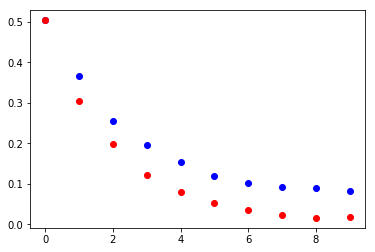

In [19]:
from matplotlib import pyplot
pyplot.plot(ResProb, 'bo')
pyplot.plot(ResProbA, 'ro')
pyplot.show()


In [72]:
print(len(dataX[0]) )     

101


In [55]:
# pick a random seed
start = np.random.randint(0, len(dataX)-1)
#start = 0
pattern = dataX[start]
print(len(pattern))
seed = dataX[start]
print(pattern)
print("Seed pattern:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

101
[45, 43, 44, 19, 24, 17, 32, 36, 21, 34, 1, 25, 10, 1, 20, 31, 39, 30, 1, 36, 24, 21, 1, 34, 17, 18, 18, 25, 36, 9, 24, 31, 28, 21, 0, 0, 17, 28, 25, 19, 21, 1, 39, 17, 35, 1, 18, 21, 23, 25, 30, 30, 25, 30, 23, 1, 36, 31, 1, 23, 21, 36, 1, 38, 21, 34, 41, 1, 36, 25, 34, 21, 20, 1, 31, 22, 1, 35, 25, 36, 36, 25, 30, 23, 1, 18, 41, 1, 24, 21, 34, 1, 35, 25, 35, 36, 21, 34, 1, 31, 22]
Seed pattern:
" ï»¿chapter i. down the rabbit-hole

alice was beginning to get very tired of sitting by her sister of "


In [47]:
generated_text = []

# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = generative_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    pattern.append(index)
    generated_text.append(index)
    pattern = pattern[1:len(pattern)]
print("\nDone.")


Done.


In [48]:
print(pattern)
print("\"", ''.join([int_to_char[value] for value in seed]), "\"")
print("\"", ''.join([int_to_char[value] for value in generated_text]), "\"")

[25, 30, 21, 1, 17, 18, 31, 37, 36, 1, 36, 24, 21, 1, 39, 24, 25, 36, 21, 1, 23, 17, 20, 1, 17, 1, 18, 31, 30, 27, 1, 36, 34, 1, 36, 24, 21, 1, 39, 31, 34, 20, 35, 1, 4, 1, 0, 4, 25, 1, 20, 31, 30, 4, 36, 1, 27, 30, 31, 39, 1, 36, 24, 21, 1, 39, 24, 25, 36, 21, 1, 34, 37, 21, 21, 34, 1, 35, 24, 21, 1, 39, 17, 41, 1, 25, 36, 1, 25, 17, 20, 1, 36, 31, 1, 35, 21, 21, 1, 36]
" , that makes the world go round!"'

'somebody said,' alice whispered, 'that it's done by everybody mi "
" ine about the white gad a bonk tr the words ' 
'i don't know the white rueer she way it iad to see t "


In [49]:
generated_text = []

# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = generative_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    pattern.append(index)
    generated_text.append(index)
    pattern = pattern[1:len(pattern)]
print(pattern)
print("\"", ''.join([int_to_char[value] for value in seed]), "\"")
print("\"", ''.join([int_to_char[value] for value in generated_text]), "\"")

[24, 21, 1, 39, 17, 41, 1, 25, 30, 36, 31, 1, 36, 24, 21, 1, 21, 17, 30, 19, 21, 13, 0, 1, 1, 39, 31, 37, 28, 20, 1, 41, 31, 37, 1, 36, 21, 28, 28, 1, 29, 21, 1, 41, 31, 37, 1, 23, 17, 20, 1, 36, 31, 1, 35, 21, 21, 1, 36, 24, 21, 1, 39, 17, 41, 1, 25, 30, 1, 36, 24, 21, 1, 39, 17, 41, 1, 25, 30, 1, 36, 24, 21, 1, 39, 17, 41, 1, 25, 30, 1, 36, 24, 21, 1, 39, 17, 41, 1, 25]
" , that makes the world go round!"'

'somebody said,' alice whispered, 'that it's done by everybody mi "
" he way into the eance?
  would you tell me you gad to see the way in the way in the way in the way i "


In [50]:
generated_text = []

# generate characters
for i in range(500):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = generative_model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    pattern.append(index)
    generated_text.append(index)
    pattern = pattern[1:len(pattern)]
print(pattern)
print("\"", ''.join([int_to_char[value] for value in seed]), "\"")
print("\"", ''.join([int_to_char[value] for value in generated_text]), "\"")

[1, 18, 21, 1, 17, 1, 32, 21, 36, 19, 34, 1, 24, 34, 31, 39, 1, 36, 24, 21, 1, 39, 24, 25, 36, 21, 1, 31, 17, 20, 21, 1, 31, 22, 1, 36, 24, 21, 1, 35, 31, 31, 28, 8, 1, 17, 30, 20, 1, 36, 24, 21, 1, 29, 31, 19, 35, 36, 21, 34, 35, 1, 25, 1, 24, 17, 38, 21, 1, 20, 31, 30, 21, 1, 36, 31, 1, 36, 24, 21, 1, 39, 31, 34, 20, 35, 1, 24, 31, 36, 1, 36, 31, 1, 36, 24, 21, 1, 39, 31]
" , that makes the world go round!"'

'somebody said,' alice whispered, 'that it's done by everybody mi "
" n the way in the way of starpelte that she had to sto the white rabbit heard the white rabbit, who was she white rabbit reterely at the white rabbit, whth a soor lany and frownen to the words the whole party things at the way of say that she was not and seneating the white rabbit, who was she white rabbit reterpadly, 'i should think you con't know the white giddres,' she said to herself, 'it would be a petcr hrow the white oade of the sool, and the mocsters i have done to the words hot to the wo "
